In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

DATA_EXT = (Path(os.getcwd()) / os.pardir / 'data' / 'external').resolve()

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [3]:
sheet_dfs = pd.read_excel(Path('../data/raw/coverage_estimates_series.xlsx'), sheet_name=None)
wuenic = pd.concat(list(sheet_dfs.values())[1:], axis=0)
wuenic.head()

1980  1981  1982  1983  1984  1985  1986  1987  1988  1989   ...     2011  \
0   NaN   NaN  10.0  10.0  11.0  17.0  18.0  27.0  40.0  38.0   ...     71.0   
1  93.0  93.0  92.0  90.0  90.0  92.0  92.0  92.0  92.0  94.0   ...     97.0   
2   NaN   NaN   NaN   NaN   NaN  86.0  88.0  93.0  96.0  96.0   ...     99.0   
3   NaN   NaN   NaN  25.0  28.0  28.0  32.0  29.0  32.0  47.0   ...     88.0   
4  62.0  70.0  77.0  70.0  78.0  90.0  99.0  94.0  91.0  92.0   ...     99.0   

   2012  2013  2014  2015  2016        Cname  ISO_code  Region  Vaccine  
0  78.0  72.0  74.0  74.0  74.0  Afghanistan       AFG     EMR      BCG  
1  96.0  99.0  99.0  99.0  99.0      Albania       ALB     EUR      BCG  
2  99.0  99.0  99.0  99.0  99.0      Algeria       DZA     AFR      BCG  
3  87.0  85.0  81.0  79.0  58.0       Angola       AGO     AFR      BCG  
4  99.0  99.0  99.0  96.0  92.0    Argentina       ARG     AMR      BCG  

[5 rows x 41 columns]

In [4]:
new_index = ['ISO_code', 'Vaccine']
numeric = [c for c in wuenic if len(c) == 4 and c[:2] in ('19', '20')]
df = wuenic.loc[:, new_index + sorted(numeric)]
df = df.loc[df[new_index].notnull().all(axis=1), :].set_index(new_index)
df.head()

1980  1981  1982  1983  1984  1985  1986  1987  1988  1989  \
ISO_code Vaccine                                                               
AFG      BCG       NaN   NaN  10.0  10.0  11.0  17.0  18.0  27.0  40.0  38.0   
ALB      BCG      93.0  93.0  92.0  90.0  90.0  92.0  92.0  92.0  92.0  94.0   
DZA      BCG       NaN   NaN   NaN   NaN   NaN  86.0  88.0  93.0  96.0  96.0   
AGO      BCG       NaN   NaN   NaN  25.0  28.0  28.0  32.0  29.0  32.0  47.0   
ARG      BCG      62.0  70.0  77.0  70.0  78.0  90.0  99.0  94.0  91.0  92.0   

                  ...   2007  2008  2009  2010  2011  2012  2013  2014  2015  \
ISO_code Vaccine  ...                                                          
AFG      BCG      ...   60.0  66.0  64.0  68.0  71.0  78.0  72.0  74.0  74.0   
ALB      BCG      ...   98.0  99.0  97.0  99.0  97.0  96.0  99.0  99.0  99.0   
DZA      BCG      ...   99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0   
AGO      BCG      ...   88.0  87.0  83.0  93.0  88.0  87.0  85.0  81.0  79.0   
ARG      BCG      ...   99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  96.0   

                  2016  
ISO_code Vaccine        
AFG      BCG      74.0  
ALB      BCG      99.0  
DZA      BCG      99.0  
AGO      BCG      58.0  
ARG      BCG      92.0  

[5 rows x 37 columns]

In [13]:
tidy = df.stack().reset_index()
tidy.columns = ['alpha3', 'vaccine', 'year', 'coverage']
tidy.year = tidy.year.astype(np.int)
tidy.head(10)

alpha3 vaccine  year  coverage
0    AFG     BCG  1982      10.0
1    AFG     BCG  1983      10.0
2    AFG     BCG  1984      11.0
3    AFG     BCG  1985      17.0
4    AFG     BCG  1986      18.0
5    AFG     BCG  1987      27.0
6    AFG     BCG  1988      40.0
7    AFG     BCG  1989      38.0
8    AFG     BCG  1990      30.0
9    AFG     BCG  1991      21.0

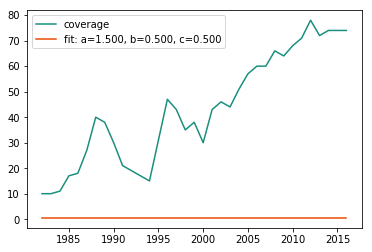

In [33]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

curr = tidy.loc[(tidy.alpha3 == 'AFG') & (tidy.vaccine == 'BCG')]
xs = curr.year
ys = curr.coverage
popt, pcov = curve_fit(func, xs, ys, bounds=(0, [3., 1., 0.5]))

plt.plot(xs, ys)
plt.plot(xs, func(xs, *popt), label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.show()

CPU times: user 1min 14s, sys: 1min, total: 2min 15s
Wall time: 48.2 s


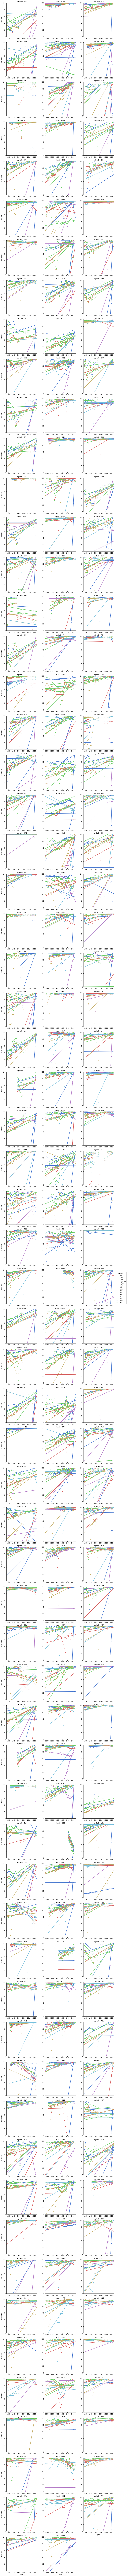

In [57]:
%%time
lm = sns.lmplot(x="year", y="coverage", col="alpha3", hue="vaccine", col_wrap=3, data=tidy,
                sharex=False, sharey=False, ci=None, palette="muted", size=4,
                scatter_kws={"s": 20, "alpha": 1})
axes = lm.axes
for ax in axes.ravel():
    ax.set_xlim(1988, 2018)
    ax.set_ylim(0.0, 100.0)

In [45]:
from arch.univariate import GARCH, ARX

In [38]:
from arch import arch_model
am = arch_model(ys)
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 148.50459610104375
Iteration:     10,   Func. Count:     62,   Neg. LLF: 148.22557410210115
Iteration:     15,   Func. Count:     92,   Neg. LLF: 148.16321920705593
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 148.12671464787942
            Iterations: 19
            Function evaluations: 116
            Gradient evaluations: 19


In [39]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               coverage   R-squared:                      -0.063
Mean Model:             Constant Mean   Adj. R-squared:                 -0.063
Vol Model:                      GARCH   Log-Likelihood:               -148.127
Distribution:                  Normal   AIC:                           304.253
Method:            Maximum Likelihood   BIC:                           310.475
                                        No. Observations:                   35
Date:                Thu, Mar 22 2018   Df Residuals:                       31
Time:                        22:54:44   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            37.4425      4.263      8.784  1.583e-18 [ 29.088, 45.79

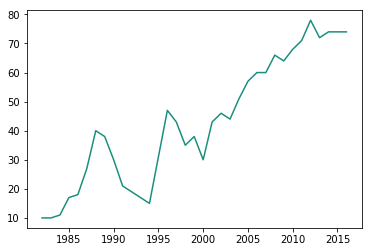

In [40]:
plt.plot(xs, ys)

Iteration:      5,   Func. Count:     55,   Neg. LLF: 91.75494480275611
Iteration:     10,   Func. Count:    103,   Neg. LLF: 91.36361600741904
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 91.36260922718459
            Iterations: 14
            Function evaluations: 139
            Gradient evaluations: 14

AFG
--------------------------------------------------------------------------------
                           AR - GARCH Model Results                           
Dep. Variable:               coverage   R-squared:                       0.895
Mean Model:                        AR   Adj. R-squared:                  0.883
Vol Model:                      GARCH   Log-Likelihood:               -91.3626
Distribution:                  Normal   AIC:                           196.725
Method:            Maximum Likelihood   BIC:                           206.296
                                        No. Observations:                   29
Date: 

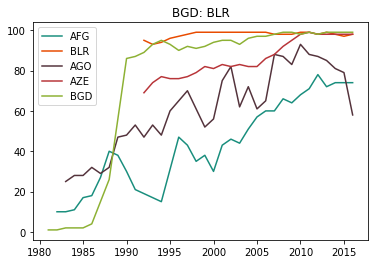

In [56]:
fig, ax = plt.subplots()

for country in ('AFG', 'BLR', 'AGO', 'AZE', 'BGD'):
    curr = tidy.loc[(tidy.alpha3 == country) & (tidy.vaccine == 'BCG')]
    xs = curr.year
    ys = curr.coverage

    ar = ARX(ys, lags=[1, 3, 6])
    ar.volatility = GARCH(p=1, q=1)
    res = ar.fit(update_freq=5)
    print('\n' + country)
    print('-' * 80)
    print(res.summary())
    print()

    ax.plot(xs, ys, label=country)
    ax.set_title(f"{country}: BLR")
    
plt.legend()
plt.show()